## Importing all the necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.layers import Input, Dense, Average, BatchNormalization, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

## Getting the tomato dataset

In [2]:
dataset_directory_location = 'tomato_dataset'

## Listing the directories present inside tomato dataset

In [3]:
os.listdir(dataset_directory_location)

['test', 'train']

## Getting the training and testing directory location

In [4]:
train_dataset_location = os.path.join(dataset_directory_location, 'train')
test_dataset_location = os.path.join(dataset_directory_location, 'test')

## Listing all the directories present inside 'train' and 'test' directory respectively

In [5]:
os.listdir(train_dataset_location)

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___healthy',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']

In [6]:
os.listdir(test_dataset_location)

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___healthy',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']

## Viewing a 'tomato image with bacterial spot image'

In [7]:
tomato_bacterial_spot_img = os.path.join(train_dataset_location, 'Tomato___Bacterial_spot')

In [8]:
os.listdir(tomato_bacterial_spot_img)[:1]

['00416648-be6e-4bd4-bc8d-82f43f8a7240___GCREC_Bact.Sp 3110.JPG']

In [9]:
tomato_bacterial_spot_img_read = imread(os.path.join(tomato_bacterial_spot_img, '00416648-be6e-4bd4-bc8d-82f43f8a7240___GCREC_Bact.Sp 3110.JPG'))

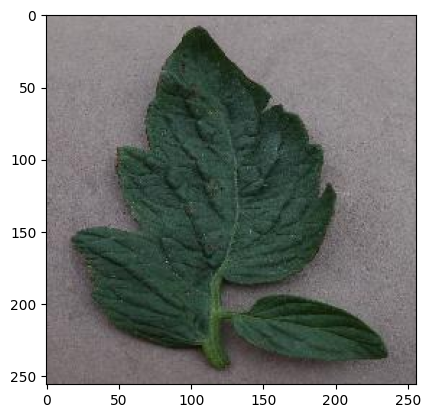

In [10]:
plt.imshow(tomato_bacterial_spot_img_read)

## Getting the shape of the image

In [11]:
tomato_bacterial_spot_img_read.shape

(256, 256, 3)

## Setting the right image shape of the image for our use case

In [12]:
correct_image_shape = (224, 224, 3)

In [13]:
image_gen = ImageDataGenerator(rotation_range=20, 
                               width_shift_range=0.1, 
                               height_shift_range=0.1, 
                               shear_range=0.1, 
                               zoom_range=0.1, 
                               horizontal_flip=True, 
                               fill_mode='nearest',
                               preprocessing_function=preprocess_input)

In [14]:
train_image_gen = image_gen.flow_from_directory(train_dataset_location, 
                                                target_size=correct_image_shape[:2], 
                                                color_mode='rgb', 
                                                batch_size=16, 
                                                class_mode='categorical')

test_image_gen = image_gen.flow_from_directory(test_dataset_location, 
                                                target_size=correct_image_shape[:2], 
                                                color_mode='rgb', 
                                                batch_size=16, 
                                                class_mode='categorical')

Found 10000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


## Creating and training the model

In [15]:
resnet50_model = load_model('resnet50_model', compile=False)
cnnfromscratch_model = load_model('cnnfromscratch_model', compile=False)

In [16]:
resnet50_model._name = 'model1'
cnnfromscratch_model._name = 'model2'

In [17]:
models = [resnet50_model, cnnfromscratch_model]

In [18]:
model_input = Input(shape=correct_image_shape)

In [19]:
model_output = [model(model_input) for model in models]

In [20]:
x = Average()(model_output)

x = BatchNormalization()(x)

x = Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))(x)
x = BatchNormalization()(x)

x = Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))(x)
x = BatchNormalization()(x)

x = Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))(x)
x = BatchNormalization()(x)

x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)


output_of_the_model = Dense(10, activation='softmax')(x)

In [21]:
ensemble_model = Model(model_input, output_of_the_model)

In [22]:
ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model1 (Sequential)            (None, 10)           18037994    ['input_1[0][0]']                
                                                                                                  
 model2 (Sequential)            (None, 10)           23997655    ['input_1[0][0]']                
                                                                                                  
 model3 (Sequential)            (None, 10)           1294538     ['input_1[0][0]']            

In [23]:
ensemble_model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(), metrics=['accuracy'])

In [24]:
ensemble_model.fit(train_image_gen, validation_data=test_image_gen, epochs=30)

Epoch 1/30
625/625 [==============================] - 241s 322ms/step - loss: 6.7690 - accuracy: 0.8004 - val_loss: 2.2463 - val_accuracy: 0.7980
Epoch 2/30
625/625 [==============================] - 177s 282ms/step - loss: 1.2959 - accuracy: 0.8794 - val_loss: 0.9832 - val_accuracy: 0.8830
Epoch 3/30
625/625 [==============================] - 168s 268ms/step - loss: 0.7781 - accuracy: 0.9076 - val_loss: 0.8503 - val_accuracy: 0.9000
Epoch 4/30
625/625 [==============================] - 161s 257ms/step - loss: 0.6433 - accuracy: 0.9168 - val_loss: 0.7537 - val_accuracy: 0.8980
Epoch 5/30
625/625 [==============================] - 160s 256ms/step - loss: 0.5580 - accuracy: 0.9220 - val_loss: 0.6814 - val_accuracy: 0.8870
Epoch 6/30
625/625 [==============================] - 159s 255ms/step - loss: 0.5045 - accuracy: 0.9269 - val_loss: 0.6887 - val_accuracy: 0.8820
Epoch 7/30
625/625 [==============================] - 162s 258ms/step - loss: 0.5161 - accuracy: 0.9228 - val_loss: 0.5776 -

In [25]:
history_df = pd.DataFrame(ensemble_model.history.history)

<Axes: >

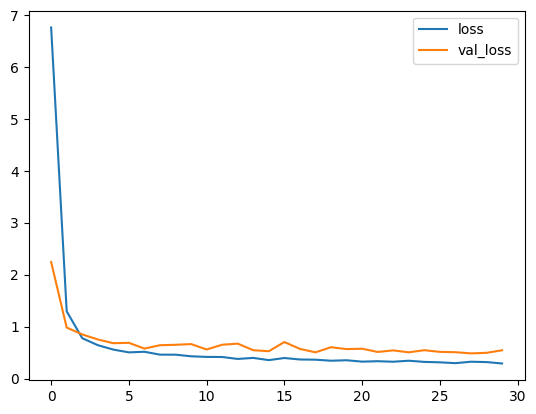

In [26]:
history_df[['loss', 'val_loss']].plot()

<Axes: >

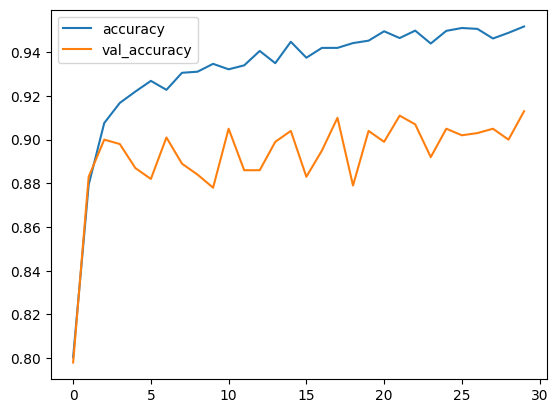

In [27]:
history_df[['accuracy', 'val_accuracy']].plot()

## Calculating the accuracy on training and testing data

In [28]:
ensemble_model.evaluate(train_image_gen)[1]

625/625 [==============================] - 146s 233ms/step - loss: 0.2088 - accuracy: 0.9772


0.9771999716758728

In [29]:
ensemble_model.evaluate(test_image_gen)[1]

63/63 [==============================] - 14s 218ms/step - loss: 0.5586 - accuracy: 0.9020


0.9020000100135803

## Making prediction on sample data

In [30]:
sample_img_load = image.load_img('./tomato_dataset/test/Tomato___Tomato_mosaic_virus/00c07a77-15e6-4815-92d4-8d1e1afb7f3c___PSU_CG 2052.JPG', target_size=correct_image_shape)

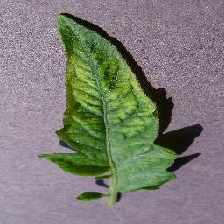

In [31]:
sample_img_load

In [32]:
sample_img_to_arr = image.img_to_array(sample_img_load) 

In [33]:
sample_img_to_arr_preprocess_input = preprocess_input(sample_img_to_arr)

In [34]:
sample_img_to_arr_expand_dim = np.expand_dims(sample_img_to_arr_preprocess_input, 0) 

In [35]:
prediction = ensemble_model.predict(sample_img_to_arr_expand_dim)[0]

1/1 [==============================] - 5s 5s/step


In [36]:
pred_result = np.argmax(prediction)

In [37]:
class_names = ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']

In [38]:
pred_final_result = class_names[pred_result]

In [39]:
pred_final_result

'Tomato___Tomato_mosaic_virus'